# Imports + Colab

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE


In [2]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2024-10-24 08:00:15--  https://fem-on-colab.github.io/releases/firedrake-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4581 (4.5K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.47K  --.-KB/s    in 0s      

2024-10-24 08:00:15 (50.3 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4581/4581]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/13b09a2/rele

/usr/local/lib/python3.10/dist-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [3]:
%cd ../../../PyGeM
%ls

/gdrive/MyDrive/PyGeM
build/             dist/         LICENSE.rst      readme/    test.py
CITATION.cff       dockerfiles/  pygem/           README.md  tests/
code_formatter.sh  docs/         pygem.egg-info/  setup.py   tutorials/


In [4]:
!python3.10 setup.py install
import pygem

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https

In [5]:
%cd ../Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
%ls

/gdrive/MyDrive/Colab Notebooks/ProgettoNAPDE/ProgettoNAPDE
 controlpoints.png   output/                     'Progetto Napde.ipynb'   testairfoil.msh
 gmshcommands.txt    Progetto_Napde_final.ipynb   testairfoil.geo


## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
from pygem import FFD, RBF
import numpy as np

# Import the mesh

In [36]:
M = Mesh('testairfoil.msh')

# Plot the mesh

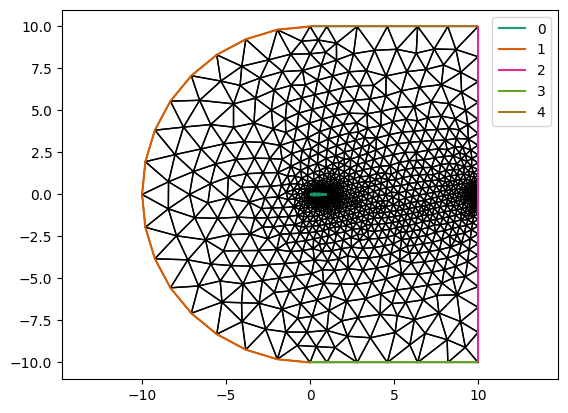

In [8]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.legend()

(-0.35, 0.35)

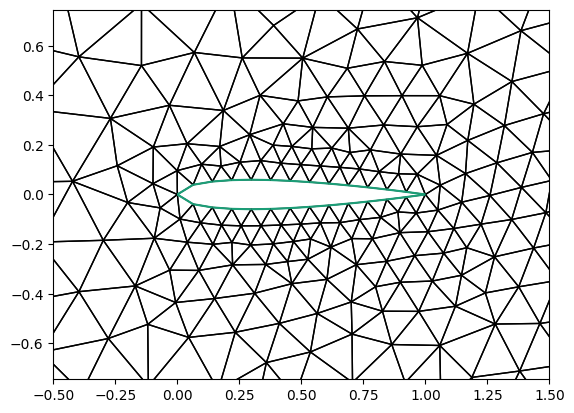

In [9]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)

# Solve problem with SUPG N-S with Stokes starting point

## Solve stokes to obtain a starting point

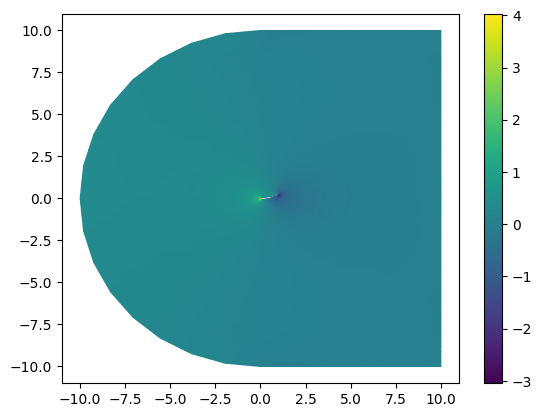

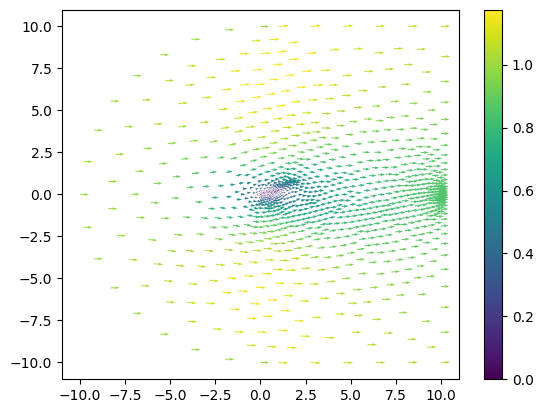

In [53]:
# function space
V=VectorFunctionSpace(M, 'P', 2) # velocity
Q=FunctionSpace(M, 'P', 1) # pressure
W=MixedFunctionSpace([V, Q])

# trial and test functions
u, p=TrialFunctions(W)
v, q=TestFunctions(W)

# data
x=SpatialCoordinate(M)
Uinf=as_vector([1,0])

# problem
a=inner(grad(u), grad(v))*dx - p*div(v)*dx+ q*div(u)*dx
L=inner(Constant((0,0)),v)*dx

# Dirichlet BC
bc1=DirichletBC(W.sub(0), as_vector([0,0]), 0)
bc2=DirichletBC(W.sub(0), Uinf, 1)
bcs=(bc1, bc2)

#solution
w_stokes=Function(W)
solve(a==L, w_stokes, bcs=bcs)
# u_h, p_h=split(wh) no split command works only for trial and test funtion
u_stokes, p_stokes=w_stokes.subfunctions

fig, ax = plt.subplots()
q=tripcolor(p_stokes, axes=ax)
fig.colorbar(q)
fig, ax = plt.subplots()
q=quiver(u_stokes, axes=ax)
fig.colorbar(q)

## Set Reynolds Number


In [54]:
Re = Constant(3500)

## Solve Navier Stokes with SUPG Stabilization

In [55]:
def a(u,v, Re):
    return 1/Re*inner(grad(u), grad(v))*dx

def c(w,u,v):
    return inner(dot(grad(u), w),v)*dx

def b(v,q):
    return -q*div(v)*dx

def stabilization(u_old, u, p, v, q, M, Re):
    ubar = Function(FunctionSpace(M, 'DG', 0))
    ubar.project(sqrt(inner(u_old, u_old)))
    h = CellDiameter(M)
    Re_K = h * ubar * Re
    one  = Constant(1.0)
    delta=Constant(1.0)
    delta_K = delta * conditional(gt(Re_K, one),  h/(ubar+1e-5), h*h*Re)

    L= -1.0/Re*div(grad(u))+ dot(grad(u_old), u) + dot(grad(u), u_old)+ grad(p)
    Lss = dot(grad(u_old),v) + dot(grad(v),u_old) + grad(q)

    lhs= delta_K * inner(L, Lss)*dx + delta_K*div(u)*div(v)*dx
    rhs=delta_K*inner(dot(grad(u_old), u_old), Lss)*dx

    return lhs, rhs


In [56]:
# Function spaces (mixed formulation)
V = VectorFunctionSpace(M, 'P', 2)
Q = FunctionSpace(M, 'P', 1)
W = MixedFunctionSpace([V, Q])

# Data and boundary conditions
f = Constant((0.,0.))

u_in = as_vector([1., 0.])

bc1 = DirichletBC(W.sub(0), Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
bc2 = DirichletBC(W.sub(0), u_in, 1) # Dirichlet unitary B.C. on the inflow boundary
bc3 = DirichletBC(W.sub(1), 0, 0) # Dirichlet unitary B.C. on the inflow boundary
bcs = (bc1, bc2)

In [57]:
# Trial and test functions
u, p = TrialFunctions(W) # trial functions
v, q = TestFunctions(W) # test functions

param = {'ksp_type':'gmres',
         'ksp_pc_type':'ilu',
         'ksp_maxit':1000,
         'ksp_rtol':1e-8,
         'snes_rtol':1e-3,
         'snes_maxit':100,
       }

# solution
wh = Function(W)
uh, ph = wh.subfunctions
wh.assign(w_stokes) #initialization with stokes solution

maxit=100
tol=1e-8
it=0
err=tol+1
delta=1

u_old = Function(V)
u_old.assign(uh)
p_old = Function(Q)
p_old.assign(ph)

while it < maxit and err > tol:
  lhs, rhs = stabilization(u_old, u, p, v, q, M, Re)
  G = a(u,v,Re) + c(u,u_old,v)+c(u_old,u,v)-b(u,q)+b(v,p)+lhs
  L = inner(f,v)*dx +rhs + c(u_old, u_old,v)
  pb = LinearVariationalProblem(G, L , wh, bcs=bcs)
  solver = LinearVariationalSolver(pb, solver_parameters=param)
  solver.solve()
  uh, ph = wh.subfunctions
  err = (errornorm(uh, u_old, 'H1') / norm(u_old, 'H1') + errornorm(ph, p_old, 'L2') / norm(p_old, 'L2'))
  u_old.assign(uh)
  p_old.assign(ph)
  it+=1

print(it)

44


## Plotting the solution

In [58]:
uh, ph = wh.subfunctions
outfileU = File("output/velocity.pvd")
outfileP = File("output/pressure.pvd")
uh.rename("Velocity")   # this name will be used in Paraview
ph.rename("Pressure")   # this name will be used in Paraview
outfileU.write(uh)
outfileP.write(ph)

/Users/guidopoletti/firedrake/src/firedrake/firedrake/_deprecation.py:65: UserWarning: The use of `File` for output is deprecated, please update your code to use `VTKFile` from `firedrake.output`.
  warn(


(-3.0, 3.0)

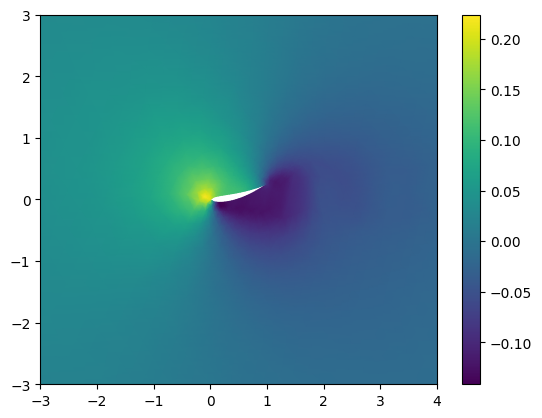

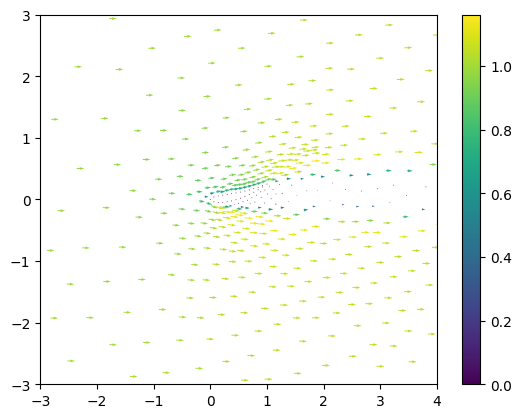

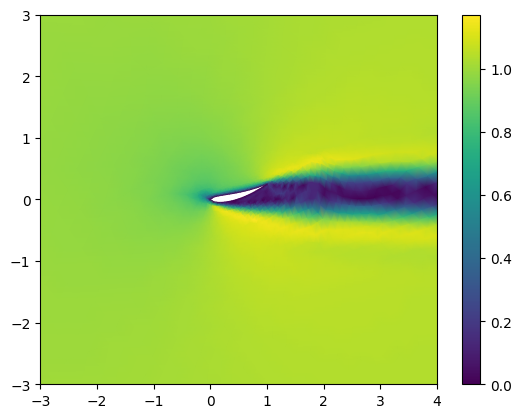

In [59]:
u_h, p_h = wh.subfunctions
fig, ax = plt.subplots()
q=tripcolor(p_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=quiver(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

fig, ax = plt.subplots()
q=tripcolor(u_h, axes=ax)
fig.colorbar(q)
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 3)

# Computing lift and drag coefficients

In [60]:
T=p_h * Identity(2) - 1/Re * (grad(u_h) + grad(u_h).T)
n=FacetNormal(M)
Cd=assemble(inner(T*n, as_vector([1,0]))*ds(0))/0.5
Cl=assemble(inner(T*n, as_vector([0,1]))*ds(0))/0.5
print(Cd)
print(Cl)

0.12918816211058204
-0.3907191489382967


# Mesh deformation

## Node Extraction

In [37]:
coord=M.coordinates.dat.data
coord.shape

(1020, 2)

In [38]:
#extend coord to make it work with FFD
coord = np.c_[coord,np.ones(coord.shape[0])]

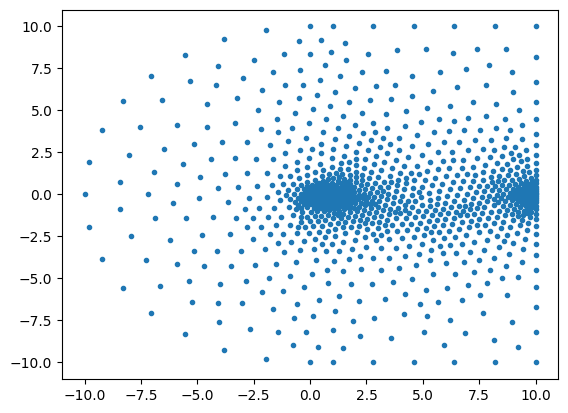

In [39]:
plt.plot(coord[:,0], coord[:,1], '.')

In [40]:
X = VectorFunctionSpace(M, 'P', 1)

b1 = DirichletBC(X, Constant((0.,0.)), 0) # Dirichlet no-slip B.C. on the airfoil
b2 = DirichletBC(X, Constant((0.,0.)), [1, 2, 3, 4]) # Dirichlet unitary B.C. on the inflow boundary


(np.float64(-0.049999999999999996),
 np.float64(1.05),
 np.float64(-0.06543444532783949),
 np.float64(0.06543444532751576))

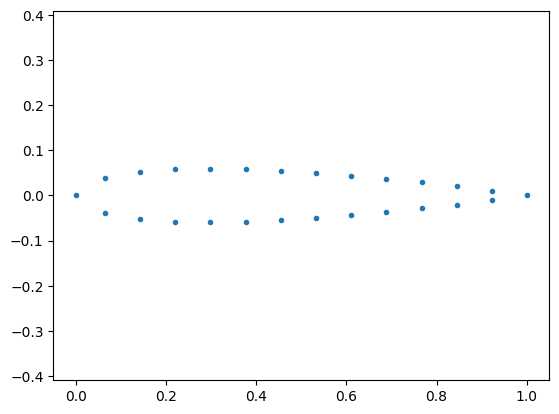

In [41]:
#extract obstacle points
obstacle=coord[b1.nodes, :]
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

(np.float64(-11.0), np.float64(11.0), np.float64(-11.0), np.float64(11.0))

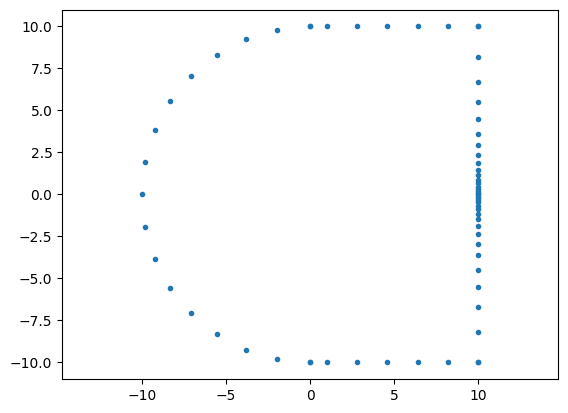

In [42]:
ext_boundary=coord[b2.nodes, :]
plt.plot(ext_boundary[:,0], ext_boundary[:,1], '.')
plt.axis('equal')


## Airfoil deformation

In [43]:
ffd = FFD([3, 3, 1]) #initialize free-form deformation object with the dimensions of the matrix of control points

#define bounding box in which object to deform is contained (position of control points)

ffd.box_origin = np.array([0,-0.5,0.9])
ffd.box_length = np.array([1,1,1.1])


(np.float64(-0.07291666666666674),
 np.float64(1.0729166666666667),
 np.float64(-0.5729166666666667),
 np.float64(0.5729166666666667),
 np.float64(0.5203125),
 np.float64(1.3796875))

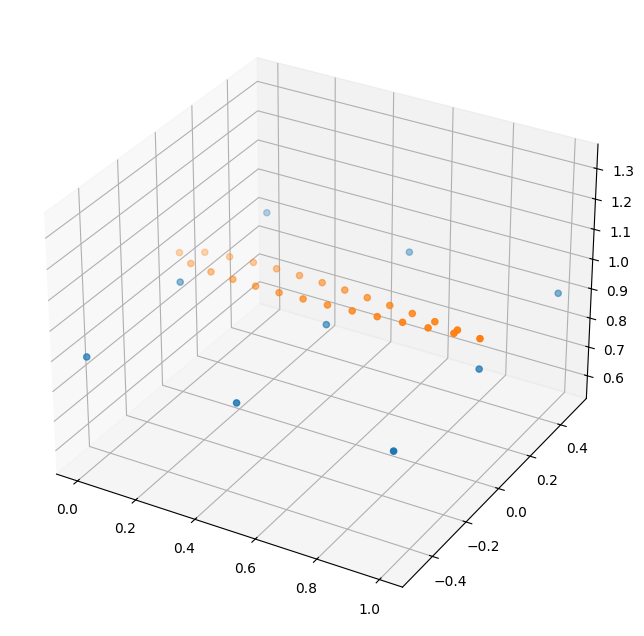

In [44]:
ax = plt.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(*ffd.control_points().T)
ax.scatter(obstacle[:,0],obstacle[:,1],obstacle[:,2])
ax.axis('equal')

In [45]:
#define movement in each direction for each control point

#ffd.array_mu_x[2, 2, 0] = 0.5
ffd.array_mu_y[2, 1, 0] = +0.5
#ffd.array_mu_z[1, 1, 0] = 0.

(np.float64(-0.0500000000000001),
 np.float64(1.05),
 np.float64(-0.07496015235840765),
 np.float64(0.2654742929694474))

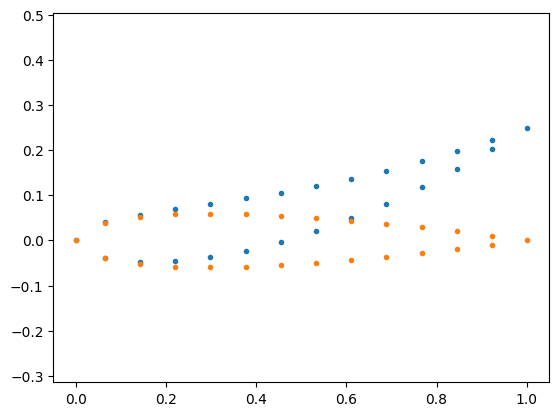

In [46]:
new_obstacle = ffd(obstacle)
plt.plot(new_obstacle[:,0], new_obstacle[:,1], '.')
plt.plot(obstacle[:,0], obstacle[:,1], '.')
plt.axis('equal')

In [47]:
undeformed_points_full = np.vstack([ext_boundary, obstacle])
deformed_points_full= np.vstack([ext_boundary, new_obstacle])

undeformed_points, uindexes = np.unique(undeformed_points_full, return_index=True, axis=0)
deformed_points   = deformed_points_full[uindexes]

rbf = RBF(original_control_points=undeformed_points, deformed_control_points=deformed_points, func='gaussian_spline',radius = 0.6)

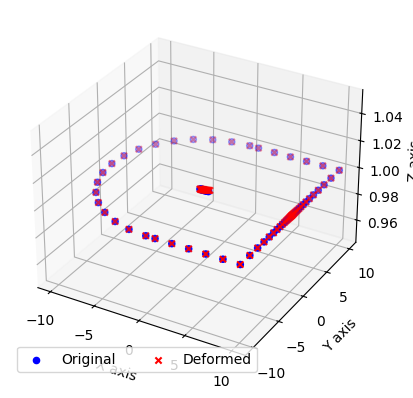

In [48]:
rbf.plot_points(filename="controlpoints")

In [49]:
#propagate deformation to the whole mesh
new_coord=rbf(coord)

(np.float64(-11.0),
 np.float64(11.0),
 np.float64(-11.000000262260437),
 np.float64(11.000000262260437))

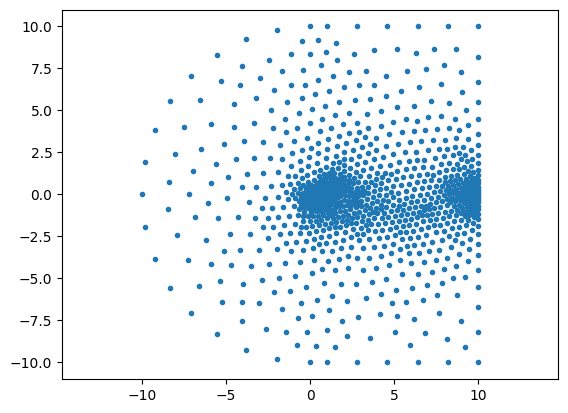

In [50]:
plt.plot(new_coord[:,0], new_coord[:,1], '.')
plt.axis('equal')

In [51]:
new_coords_func = Function(M.coordinates.function_space())
new_coords_func.dat.data[:] = new_coord[:,:2]
M.coordinates.assign(new_coords_func)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x175381650>, VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 364)), 523)

(-0.35, 0.35)

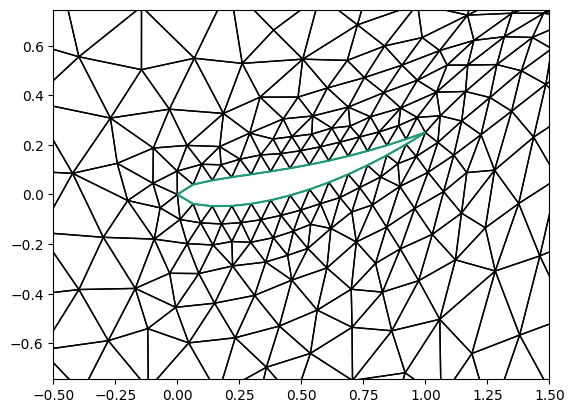

In [52]:
fig, ax = plt.subplots()
triplot(M, axes=ax)
ax.axis('equal')
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-0.35,0.35)